In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating Dataset

In [2]:
w,h = 250,250
batch_size = 16

train_path = 'xray/train/'
test_path = 'xray/test/'
val_path = 'xray/val/'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
    # preprocessing_function = exposure_contrast_setting
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    # preprocessing_function = exposure_contrast_setting
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    # preprocessing_function = exposure_contrast_setting
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [14]:
train_dataset.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

# View Images

(16, 250, 250, 3)


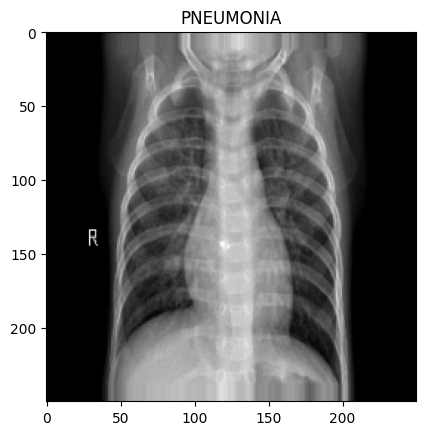

(16, 250, 250, 3)


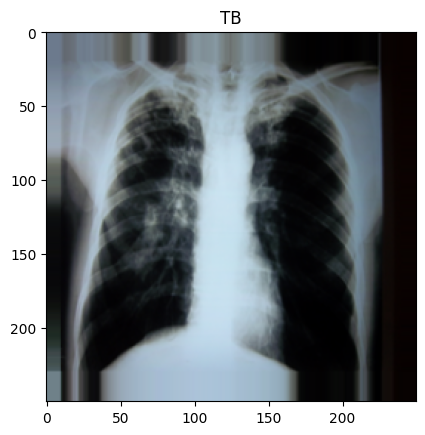

In [15]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

for _ in range(2):
    img, label = train_dataset.next()
    print(img.shape)
    plt.title(classes[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

In [16]:
train_dataset.image_shape

(250, 250, 3)

# Alexnet Architecture

In [71]:
# from tensorflow.keras import models
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = models.Sequential()

# # Convolutional layers
# model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(w, h, 3)))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# model.add(Conv2D(384, (3, 3), activation='relu'))
# model.add(Conv2D(384, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

# # Flatten layer
# model.add(Flatten())

# # Dense layers
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Print a summary of the model architecture
# model.summary()


# CNN + LSTM

In [72]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Reshape the output from the convolutional layers for LSTM
model.add(layers.Reshape((-1, 128)))

# LSTM layer
model.add(layers.LSTM(128, return_sequences=True))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


# ResNet101_v2

In [99]:
# resnetModel = models.Sequential()

# ResNet_101_V2 = tf.keras.applications.ResNet101V2(
#                 include_top = False,
#                 weights="imagenet",
#                 input_shape=(w,h,3),
#                 pooling='max',
#                 classes=4
#             )

# for layer in ResNet_101_V2.layers:
#     layer.trainable = False

# resnetModel.add(ResNet_101_V2)
# resnetModel.add(layers.Flatten())
# resnetModel.add(layers.Dense(512, activation='relu'))
# resnetModel.add(layers.Dense(128, activation='relu'))
# resnetModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# # Compile the model
# resnetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# resnetModel.summary()

# Mobile Net v2

In [98]:
# mobileModel = models.Sequential()

# MobileNetV2 = tf.keras.applications.MobileNetV2(
#                 include_top = False,
#                 weights="imagenet",
#                 input_shape=(w,h,3),
#                 pooling='max',
#                 classes=4
#             )

# for layer in MobileNetV2.layers:
#     layer.trainable = False

# mobileModel.add(MobileNetV2)
# mobileModel.add(layers.Flatten())
# mobileModel.add(layers.Dense(512, activation='relu'))
# mobileModel.add(layers.Dense(128, activation='relu'))
# mobileModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# # Compile the model
# mobileModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# mobileModel.summary()

# Training

In [85]:
steps_per_epoch = len(os.listdir(train_path))//4
val_steps_per_epoch = len(os.listdir(val_path))//2

tf.random.set_seed(42)
epoch = 10


# Save best model
weight_path = 'model/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy',
    save_freq='epoch',
    verbose = 2
) 

In [86]:
history = model.fit(train_dataset, 
                    epochs=epoch, 
                    validation_data=test_dataset, 
                    callbacks=[model_checkpoint]
                    )

In [97]:
# history = mobileModel.fit(train_dataset,
#                           epochs=epoch,
#                           validation_data=val_dataset,
#                           callbacks=[model_checkpoint])

In [88]:
# history = resnetModel.fit(train_dataset, 
#                           epochs=epoch, 
#                           validation_data=val_dataset, 
#                           callbacks=[model_checkpoint])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predictions

In [3]:
# load trained model

model = models.load_model("lime-ray-cnn-lstm-20e.h5")

In [102]:
labels = ['COVID-19','NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


# load best weights to model
# model.load_weights(weight_path)

# make predictions
predictions = model.predict(test_dataset)
# we have to get the position of the maximum value from each sample.
predicted_class = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

true_labels = test_dataset.classes

49/49 [==============================] - 8s 149ms/step


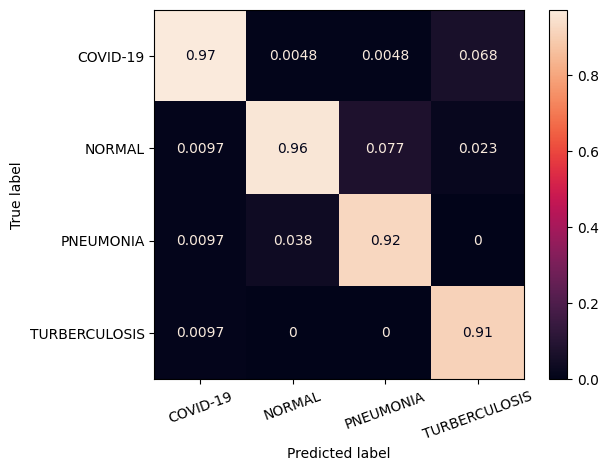

In [103]:
cm = confusion_matrix(true_labels, predicted_class, 
                      normalize='pred'
                      )
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='rocket')
plt.xticks(rotation=20)
plt.show()

In [104]:
# Print classification report

class_report = classification_report(true_labels, predicted_class, labels=[0, 1, 2, 3], target_names=labels)
print(class_report)

               precision    recall  f1-score   support

     COVID-19       0.97      0.94      0.96       106
       NORMAL       0.96      0.85      0.90       234
    PNEUMONIA       0.92      0.98      0.95       390
TURBERCULOSIS       0.91      0.98      0.94        41

     accuracy                           0.94       771
    macro avg       0.94      0.94      0.94       771
 weighted avg       0.94      0.94      0.93       771



In [45]:
# model.save('lime-ray-cnn-lstm-20e.h5')

1/1 [==============================] - 0s 202ms/step


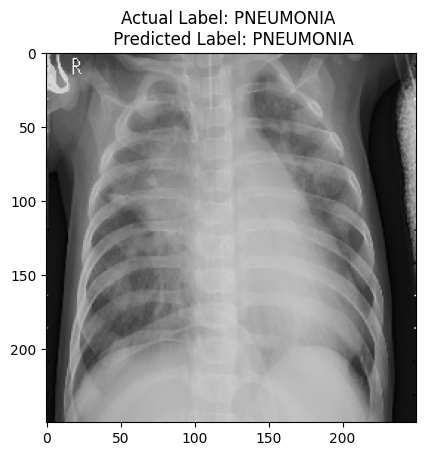

1/1 [==============================] - 0s 49ms/step


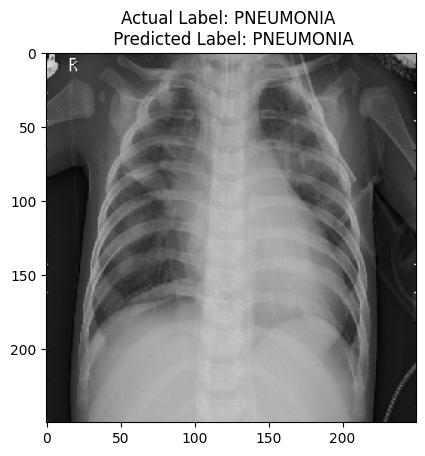

1/1 [==============================] - 0s 53ms/step


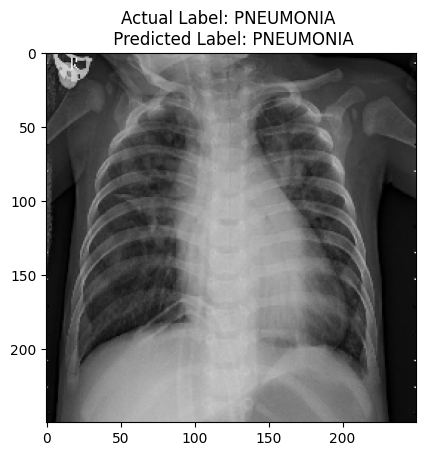

In [106]:
def singlePred(batch, im):


    actual_label = labels[np.argmax(test_dataset.__getitem__(idx=batch)[1][im])]
    pred_label = labels[np.argmax(model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]


    plt.imshow(test_dataset.__getitem__(idx=batch)[0][im])
    plt.title(f"Actual Label: {actual_label} \n Predicted Label: {pred_label}")
    plt.show()
    
for i in range(3):
    singlePred(30,i)